In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [12]:
class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X, y):
        self.n_classes_ = len(np.unique(y))
        self.n_features_ = X.shape[1]
        self.tree_ = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))
        
        if (self.max_depth is not None and depth >= self.max_depth) or n_labels == 1:
            leaf_value = self._most_common_label(y)
            return {'leaf': True, 'value': leaf_value}
        
        feature_indices = np.random.choice(n_features, n_features, replace=False)
        best_feature, best_threshold = self._best_criteria(X, y, feature_indices)
        
        left_indices, right_indices = self._split(X[:, best_feature], best_threshold)
        
        left_tree = self._grow_tree(X[left_indices, :], y[left_indices], depth + 1)
        right_tree = self._grow_tree(X[right_indices, :], y[right_indices], depth + 1)
        
        return {'feature': best_feature, 'threshold': best_threshold,
                'left': left_tree, 'right': right_tree}

    def _best_criteria(self, X, y, feature_indices):
        best_gain = -1
        best_feature, best_threshold = None, None
        for feature in feature_indices:
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                gain = self._information_gain(y, self._split(X[:, feature], threshold))
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold
        return best_feature, best_threshold

    def _information_gain(self, y, splits):
        n = len(y)
        s = 0
        for split in splits:
            s += (len(split) / n) * self._entropy(y[split])
        return self._entropy(y) - s

    def _entropy(self, y):
        unique, counts = np.unique(y, return_counts=True)
        probs = counts / len(y)
        return -np.sum(probs * np.log2(probs))

    def _split(self, X_column, threshold):
        return np.where(X_column <= threshold)[0], np.where(X_column > threshold)[0]

    def _most_common_label(self, y):
        return np.argmax(np.bincount(y))

    def predict(self, X):
        return [self._predict(inputs) for inputs in X]

    def _predict(self, inputs):
        node = self.tree_
        while True:
            if node.get('leaf'):
                return node.get('value')
            if inputs[node['feature']] <= node['threshold']:
                node = node['left']
            else:
                node = node['right']

In [13]:
class RandomForest:
    def __init__(self, n_estimators=100, max_depth=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.estimators = [DecisionTree(max_depth=self.max_depth) for _ in range(self.n_estimators)]

    def fit(self, X, y):
        for estimator in self.estimators:
            bootstrap_indices = np.random.choice(len(X), len(X), replace=True)
            X_bootstrap = X[bootstrap_indices]
            y_bootstrap = y[bootstrap_indices]
            estimator.fit(X_bootstrap, y_bootstrap)

    def predict(self, X):
        predictions = np.array([estimator.predict(X) for estimator in self.estimators])
        return np.mean(predictions, axis=0).astype(int)

In [16]:
df = pd.read_csv('/Users/sandundesilva/Documents/4th year/Research Project/UI/findMyFilm/flask-server/Models/final/Benchmark/movies.csv')

texts = df['subtitles'].values
labels = df['genre'].values

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(texts)

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

rf_classifier = RandomForest(n_estimators=50, max_depth=5)
rf_classifier.fit(X_train.toarray(), y_train_encoded)

predictions = rf_classifier.predict(X_test.toarray())

report = classification_report(y_test_encoded, predictions)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         0
           6       0.11      0.17      0.13         6
           7       0.18      0.50      0.27         4
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         4
          16       0.00      0.00      0.00         4
          17       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         4

    accuracy                           0.09        34
   macro avg       0.02      0.05      0.03        34
weighted avg       0.04      0.09      0.05        34



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

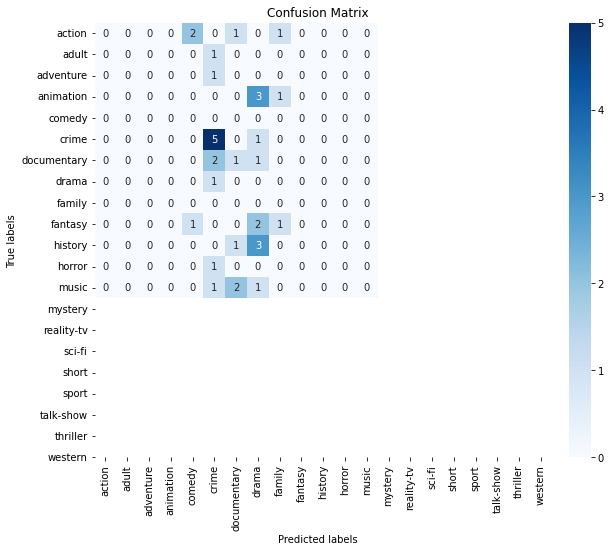

In [18]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
